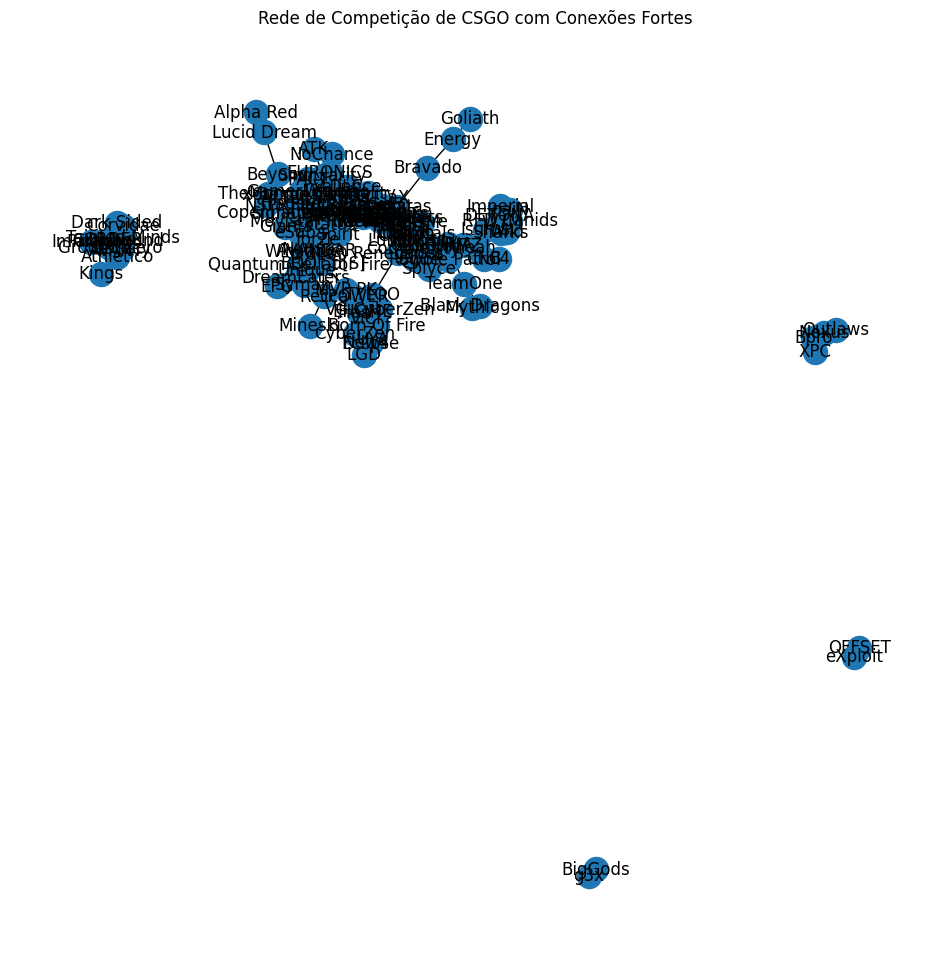

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Definições iniciais
minRivalry = 15  # Limiar para considerar uma conexão significativa

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Criar um grafo não direcionado
G = nx.Graph()

# Adicionar arestas ao grafo com base nas partidas
for index, row in df.iterrows():
    # Adiciona arestas entre team_1 e team_2
    # Se a aresta já existir, aumenta o peso (representando outra partida)
    if G.has_edge(row['team_1'], row['team_2']):
        G.edges[row['team_1'], row['team_2']]['weight'] += 1
    else:
        G.add_edge(row['team_1'], row['team_2'], weight=1)

# Filtrar arestas com peso maior que {minRivalry}
# Criar uma cópia do grafo para modificar
H = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] > minRivalry:
        H.add_edge(u, v, weight=data['weight'])

# Agora H contém apenas as arestas com peso maior que {minRivalry}

# Visualização
if len(H) > 0:  # Se o grafo não estiver vazio
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(H)  # Posicionamento dos nós
    nx.draw_networkx_nodes(H, pos)
    nx.draw_networkx_edges(H, pos)
    nx.draw_networkx_labels(H, pos)
    plt.title('Rede de Competição de CSGO com Conexões Fortes')
    plt.axis('off')  # Desliga os eixos
    plt.show()
else:
    print(f"Não existem conexões com peso acima de {minRivalry} no grafo.")

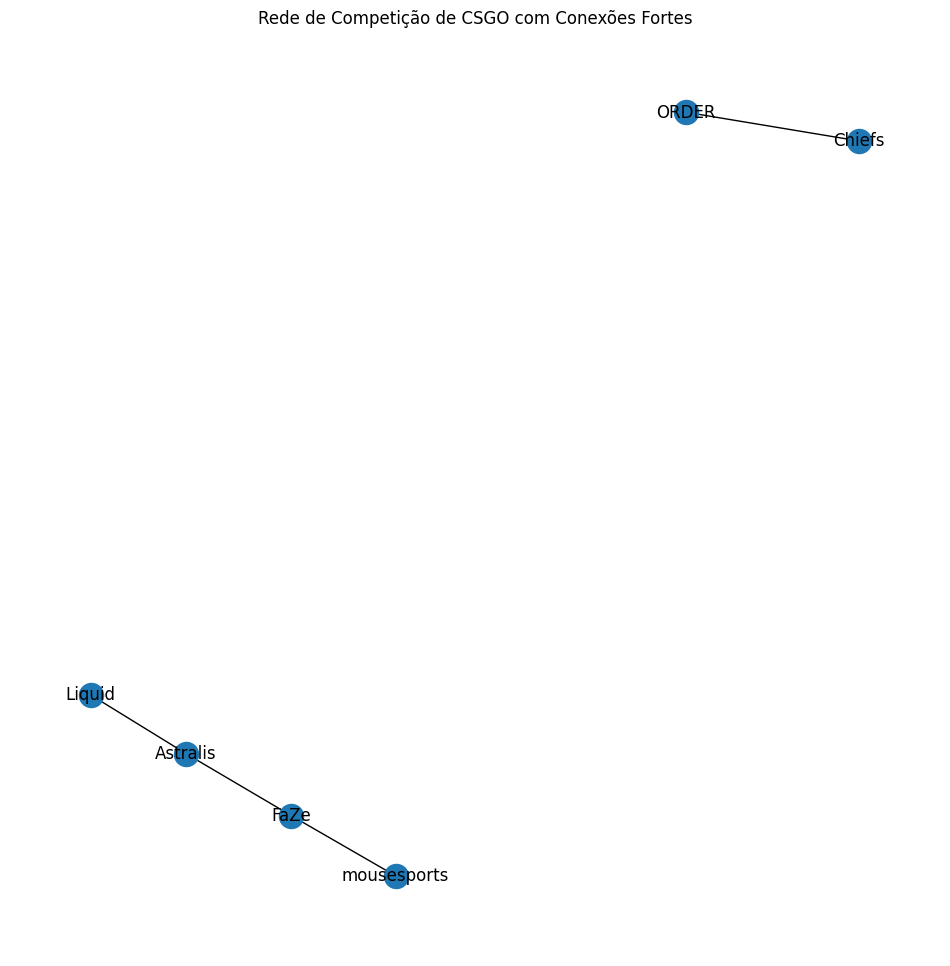

In [2]:
# Strength of Ties
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Definições iniciais
minRivalry = 15  # Limiar para considerar uma conexão significativa

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Convertendo as colunas de resultado para inteiros
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')

# Criar um grafo não direcionado
G = nx.Graph()

# Adicionar arestas ao grafo com base nas partidas
for index, row in df.iterrows():
    # Calcular o peso com base na diferença de pontuação
    score_diff = abs(row['result_1'] - row['result_2'])
    weight = 1 if score_diff == 0 else 1 / score_diff  # Evitar divisão por zero
    
    # Verifica quem é o vencedor e ajusta o peso se necessário
    # Considerando que map_winner seja '1' ou '2', indicando o vencedor
    if row['map_winner'] == '1':  # Se team_1 é o vencedor
        weight += 1
    elif row['map_winner'] == '2':  # Se team_2 é o vencedor
        weight += 1
    
    # Adiciona ou atualiza a aresta com o novo peso
    if G.has_edge(row['team_1'], row['team_2']):
        G.edges[row['team_1'], row['team_2']]['weight'] += weight
    else:
        G.add_edge(row['team_1'], row['team_2'], weight=weight)

# Filtrar arestas com peso maior que o limiar de rivalidade
H = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] > minRivalry:
        H.add_edge(u, v, weight=data['weight'])

# Visualização
if len(H) > 0:
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos)
    nx.draw_networkx_edges(H, pos)
    nx.draw_networkx_labels(H, pos)
    plt.title('Rede de Competição de CSGO com Conexões Fortes')
    plt.axis('off')
    plt.show()
else:
    print(f"Não existem conexões com peso acima de {minRivalry} no grafo.")


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Define equipe para analisar
team_to_analyze = 'FaZe'

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Converter as datas para o tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Filtrar as partidas que incluem a equipe de interesse
df_team = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

# Criar um grafo para cada data em que a equipe de interesse jogou
graphs_by_date = {}
for date, group in df_team.groupby('date'):
    G = nx.Graph()
    for i, row in group.iterrows():
        # Adiciona equipe adversária como nó no grafo
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        G.add_edge(team_to_analyze, opponent, weight=1)
    graphs_by_date[date] = G

# Agora é possível analisar cada grafo para ver com quais equipes a equipe de interesse jogou em cada data
# Aqui imprime os oponentes e a data de cada jogo
for date, graph in graphs_by_date.items():
    opponents = list(nx.neighbors(graph, team_to_analyze))
    print(f"Em {date.date()}, {team_to_analyze} jogou contra: {opponents}")

# Para visualizar as conexões de uma data específica, insira a data aqui:
specific_date = pd.to_datetime('2020-03-18')

# Verifica se a equipe jogou nessa data e cria uma visualização
if specific_date in graphs_by_date:
    plt.figure(figsize=(8, 5))
    H = graphs_by_date[specific_date]
    pos = nx.spring_layout(H)
    nx.draw_networkx_nodes(H, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(H, pos, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=12)
    plt.title(f'Conexões de {team_to_analyze} em {specific_date.date()}')
    plt.axis('off')
    plt.show()
else:
    print(f"{team_to_analyze} não jogou em {specific_date.date()}.")


Em 2016-01-22, FaZe jogou contra: ['Luminosity', 'Natus Vincere']
Em 2016-01-23, FaZe jogou contra: ['Luminosity']
Em 2016-02-10, FaZe jogou contra: ['Virtus.pro']
Em 2016-03-03, FaZe jogou contra: ['E-frag.net', 'Tempo Storm', 'Virtus.pro', 'Astralis', 'Envy']
Em 2016-03-08, FaZe jogou contra: ['NiP']
Em 2016-03-10, FaZe jogou contra: ['Natus Vincere']
Em 2016-03-12, FaZe jogou contra: ['SK']
Em 2016-03-13, FaZe jogou contra: ['SK']
Em 2016-03-17, FaZe jogou contra: ['G2']
Em 2016-03-19, FaZe jogou contra: ['mousesports']
Em 2016-03-29, FaZe jogou contra: ['Liquid']
Em 2016-03-30, FaZe jogou contra: ['Splyce']
Em 2016-03-31, FaZe jogou contra: ['fnatic']
Em 2016-04-12, FaZe jogou contra: ['Virtus.pro']
Em 2016-04-13, FaZe jogou contra: ['Envy']
Em 2016-04-19, FaZe jogou contra: ['Virtus.pro', 'Astralis']
Em 2016-04-20, FaZe jogou contra: ['Envy', 'fnatic']
Em 2016-04-21, FaZe jogou contra: ['FlipSid3', 'Dignitas']
Em 2016-04-24, FaZe jogou contra: ['fnatic']
Em 2016-04-26, FaZe jogou 

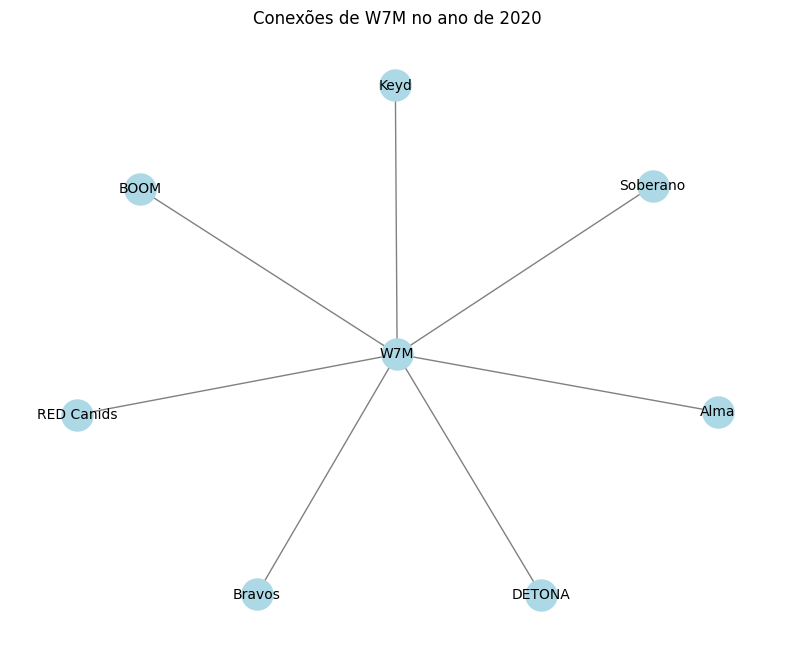

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Define equipe para analisar e o ano específico
team_to_analyze = 'W7M'  # Substitua pelo nome da equipe desejada
specific_year = 2020  # Substitua pelo ano desejado para análise

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Converter as datas para o tipo datetime e adicionar uma coluna 'year'
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Filtrar as partidas que incluem a equipe de interesse e ocorreram no ano específico
df_team_year = df[((df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)) & (df['year'] == specific_year)]

# Criar um grafo para o ano especificado
G_year = nx.Graph()
for i, row in df_team_year.iterrows():
    # Adiciona equipe adversária como nó no grafo
    opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
    G_year.add_edge(team_to_analyze, opponent, weight=1)

# Visualização do grafo para o ano especificado
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_year)  # Isso pode levar algum tempo para grafos grandes
nx.draw_networkx_nodes(G_year, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_year, pos, edge_color='gray')
nx.draw_networkx_labels(G_year, pos, font_size=10)
plt.title(f'Conexões de {team_to_analyze} no ano de {specific_year}')
plt.axis('off')
plt.show()


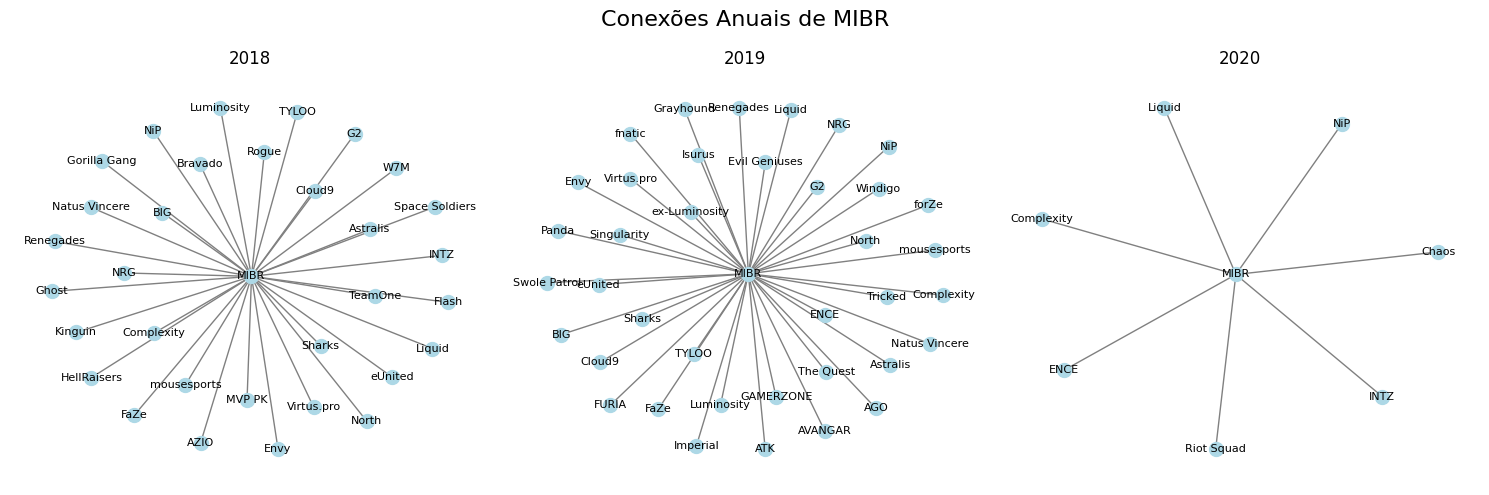

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

team_to_analyze = 'MIBR'  # Defina a equipe para analisar

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Converter as datas para o tipo datetime e adicionar uma coluna 'year'
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Filtrar as partidas que incluem a equipe de interesse
df_team = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

# Agrupar as partidas por ano e criar um grafo para cada ano
graphs_by_year = {}
for year, group in df_team.groupby('year'):
    G = nx.Graph()
    for i, row in group.iterrows():
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        G.add_edge(team_to_analyze, opponent)
    graphs_by_year[year] = G

# Configuração da visualização
fig, axes = plt.subplots(nrows=1, ncols=len(graphs_by_year), figsize=(15, 5))
fig.suptitle(f'Conexões Anuais de {team_to_analyze}', fontsize=16)

# Criar um gráfico para cada ano
for ax, (year, G) in zip(axes, graphs_by_year.items()):
    pos = nx.spring_layout(G, seed=42)  # Fornece um layout consistente
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=100, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray')
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    ax.set_title(str(year))
    ax.axis('off')

plt.tight_layout()
plt.show()


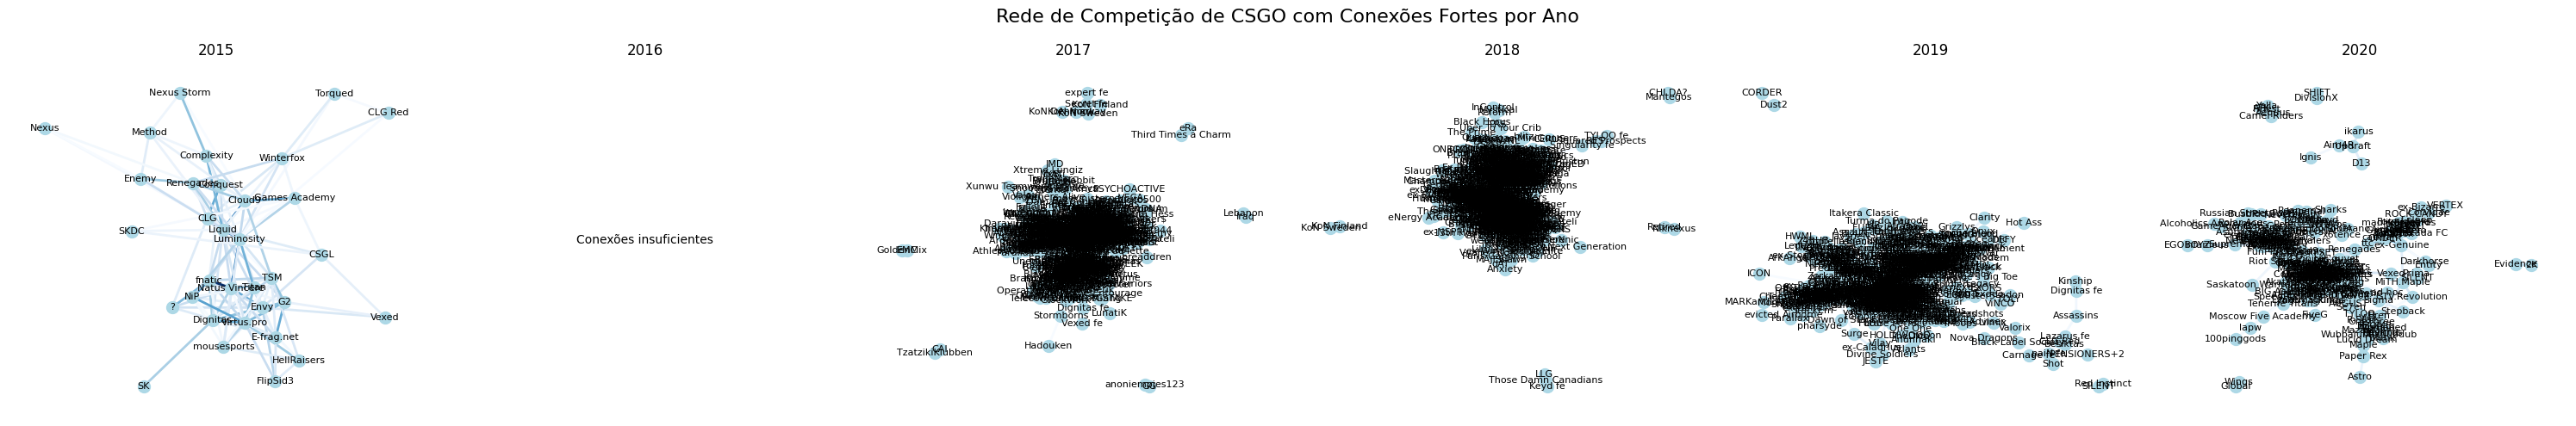

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Convertendo as colunas de resultado para inteiros e datas para datetime
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Limiar para considerar uma conexão significativa
minRivalry = 9

# Agrupar os dados por ano
grouped = df.groupby('year')

# Criar um grafo para cada ano
graphs_by_year = {}
for year, group in grouped:
    G = nx.Graph()
    for index, row in group.iterrows():
        score_diff = abs(row['result_1'] - row['result_2'])
        weight = 1 if score_diff == 0 else 1 / score_diff
        
        if row['map_winner'] == '1':
            weight += 1
        elif row['map_winner'] == '2':
            weight += 1
        
        if G.has_edge(row['team_1'], row['team_2']):
            G.edges[row['team_1'], row['team_2']]['weight'] += weight
        else:
            G.add_edge(row['team_1'], row['team_2'], weight=weight)
    graphs_by_year[year] = G

# Configuração da visualização
num_years = len(graphs_by_year)
fig, axes = plt.subplots(nrows=1, ncols=num_years, figsize=(num_years * 5, 5))
if num_years == 1:
    axes = [axes]

fig.suptitle('Rede de Competição de CSGO com Conexões Fortes por Ano', fontsize=16)

# Criar um gráfico para cada ano
for ax, (year, G) in zip(axes, graphs_by_year.items()):
    pos = nx.spring_layout(G, seed=42)
    
    # Verificar se o grafo tem arestas e se os pesos são válidos
    if G.edges and nx.get_edge_attributes(G, 'weight'):
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        
        # Verificar se todos os pesos não são zero
        if all(weight > 0 for weight in weights):
            nx.draw_networkx_nodes(G, pos, ax=ax, node_size=100, node_color='lightblue')
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges, edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
            nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
        else:
            ax.text(0.5, 0.5, 'Conexões insuficientes', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'Sem partidas neste ano', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    ax.set_title(str(year))
    ax.axis('off')

plt.tight_layout()
plt.show()

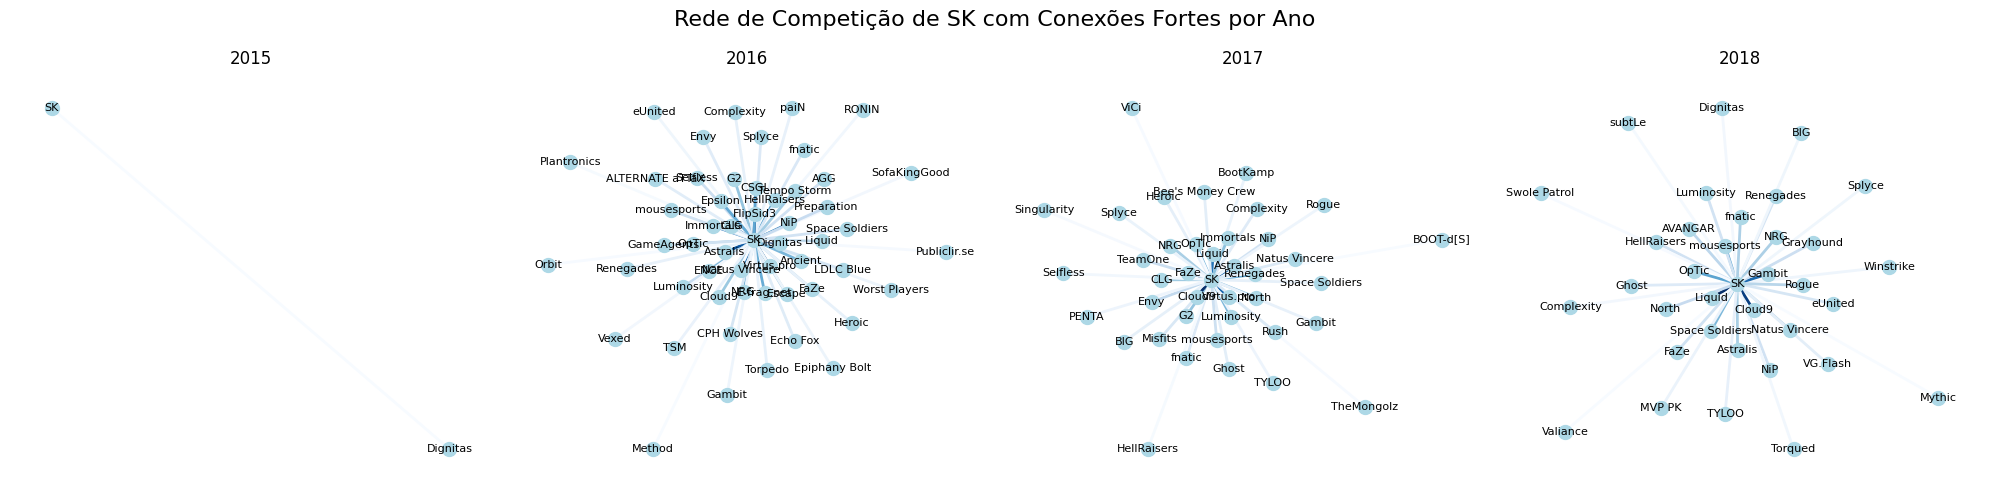

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Defina a equipe para analisar
team_to_analyze = 'SK'

# Carregar dados do CSV
df = pd.read_csv('../db/results.csv')

# Convertendo as colunas de resultado para inteiros e datas para datetime
df['result_1'] = pd.to_numeric(df['result_1'], errors='coerce')
df['result_2'] = pd.to_numeric(df['result_2'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Filtrar as partidas que incluem a equipe especificada
df_filtered = df[(df['team_1'] == team_to_analyze) | (df['team_2'] == team_to_analyze)]

minRivalry = 9

# Agrupar os dados filtrados por ano
grouped = df_filtered.groupby('year')

graphs_by_year = {}
for year, group in grouped:
    G = nx.Graph()
    for index, row in group.iterrows():
        score_diff = abs(row['result_1'] - row['result_2'])
        weight = 1 if score_diff == 0 else 1 / score_diff
        
        if row['map_winner'] == '1':
            weight += 1
        elif row['map_winner'] == '2':
            weight += 1
        
        opponent = row['team_2'] if row['team_1'] == team_to_analyze else row['team_1']
        if G.has_edge(team_to_analyze, opponent):
            G.edges[team_to_analyze, opponent]['weight'] += weight
        else:
            G.add_edge(team_to_analyze, opponent, weight=weight)
    graphs_by_year[year] = G

# Verificar se há dados suficientes para criar subplots
if not graphs_by_year:
    print(f"Não foram encontradas partidas para a equipe {team_to_analyze} em nenhum ano.")
else:
    num_years = len(graphs_by_year)
    fig, axes = plt.subplots(nrows=1, ncols=num_years, figsize=(num_years * 5, 5))
    if num_years == 1:
        axes = [axes]

    fig.suptitle(f'Rede de Competição de {team_to_analyze} com Conexões Fortes por Ano', fontsize=16)

    for ax, (year, G) in zip(axes, graphs_by_year.items()):
        pos = nx.spring_layout(G, seed=42)
        if G.edges and nx.get_edge_attributes(G, 'weight'):
            edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
            if all(weight > 0 for weight in weights):
                nx.draw_networkx_nodes(G, pos, ax=ax, node_size=100, node_color='lightblue')
                nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges, edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
                nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
            else:
                ax.text(0.5, 0.5, 'Conexões insuficientes', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'Sem partidas neste ano', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        ax.set_title(str(year))
        ax.axis('off')

    plt.tight_layout()
    plt.show()
